In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from collections import defaultdict
import folium
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from library import *
%load_ext autoreload
%autoreload 2

In [2]:
cbre_metro = 'Denver'
cbre = import_cbre(cbre_metro)

# Zip Codes in Zillow metro area
# zillow_metro = 'Denver-Aurora-Lakewood'
# zillow = import_zillow(zillow_metro)

# Zip Codes in CBRE
zillow = import_zillow(zip_code=cbre.index)

In [3]:
zillow.State.unique()

array(['CO'], dtype=object)

In [4]:
zip_centroid = import_centroid()
geojson = f'../data/co_colorado_zip_codes_geo.min.json'
coor = [39.6000, -104.9903]

In [5]:
zip_pop = import_pop()

### CBRE Map

In [6]:
get_stat(cbre,zip_pop)

,submktname,Population,Household_Count
Aurora,21,34270.0,14986.0
Boulder,20,4326.0,1929.0
Central Business District,15,0.0,0.0
Colorado Blvd / Glendale,21,20073.0,12227.0
Fort Collins / Loveland,23,10296.0,4175.0
Longmont,8,25659.0,10367.0
Midtown,7,18839.0,13116.0
North,12,29538.5,11371.0
Northeast,21,11513.5,4149.5
Northwest,23,25553.0,10796.0


In [7]:
cbre_centroid = get_centroid(cbre,zip_centroid)

In [8]:
cbre_le = preprocessing.LabelEncoder()
cbre_le.fit(cbre.submkt_id)

LabelEncoder()

In [9]:
cbre['submkt_id_label'] = cbre_le.transform(cbre.submkt_id)
cbre_map = make_map(geojson,coor,cbre.submkt_id.nunique(),
                    cbre['submkt_id_label'].reset_index(),centroid=cbre_centroid)

In [55]:
cbre_map.save('../fig/'+cbre_metro+'_cbre.html')

### Zillow Clustering

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

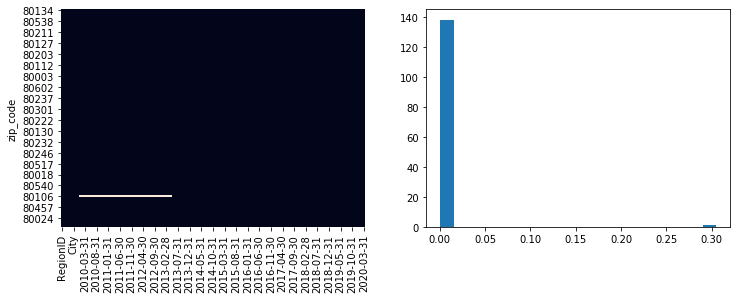

In [11]:
plot_missing(zillow)

In [12]:
zillow = zillow.dropna()

In [13]:
zillow_info,zillow_ts = split_zillow(zillow)
change = get_change(zillow_ts)

In [54]:
weight = 5
syn = get_syn(change,zip_centroid,weight)

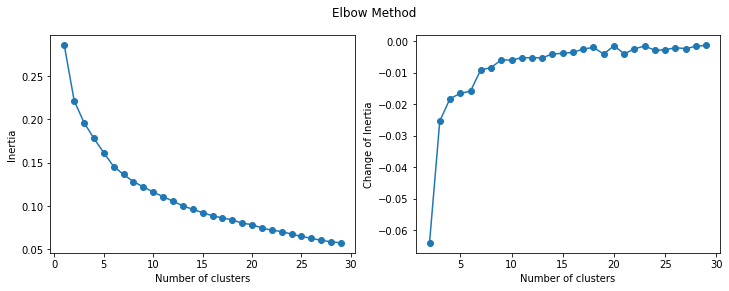

In [55]:
kmeans = KMeans(n_init=40, random_state=42)

plot_inertia(kmeans, syn, range(1, 30))

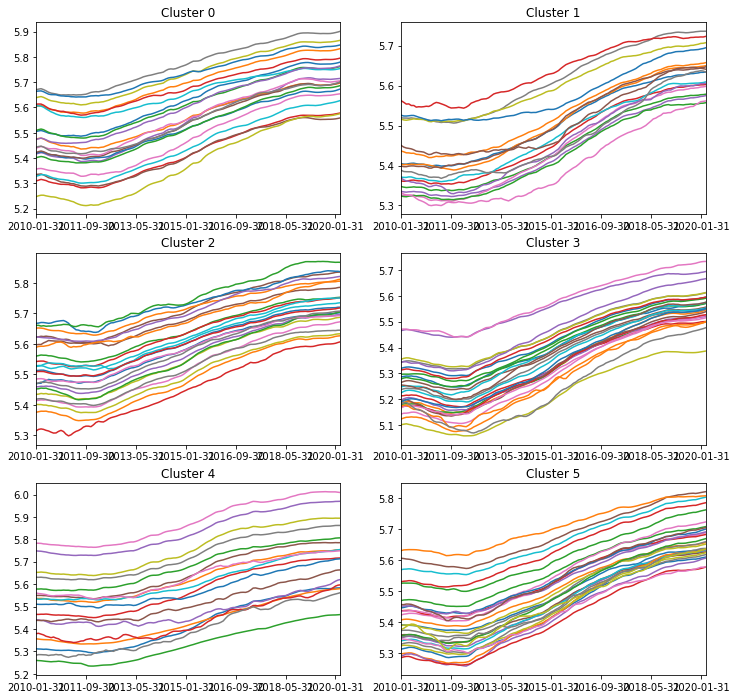

In [56]:
ncluster = 6
km_predict = fit_kmeans(ncluster, syn, kmeans)
plot_clusters(km_predict,zillow_ts)

In [57]:
geo_map = make_map(geojson,coor,ncluster,km_predict)
# geo_map
geo_map.save('../fig/'+cbre_metro+'_km_'+str(ncluster)+'.html')

In [58]:
km_predict.submktname.value_counts()

5    29
3    28
2    24
0    21
4    18
1    18
Name: submktname, dtype: int64

In [59]:
zillow_info['submktname'] = km_predict.set_index('zip_code')['submktname'].map(lambda x: 'Layer0 - '+str(x))

### Plot Submarkets

In [60]:
zillow_centroid = get_centroid(zillow_info,zip_centroid)

In [61]:
zillow_le = preprocessing.LabelEncoder()
zillow_le.fit(zillow_info.submktname)

LabelEncoder()

In [62]:
zillow_info['submktname_label'] = zillow_le.transform(zillow_info.submktname)
zillow_map = make_map(geojson,coor,zillow_info.submktname_label.nunique(),
                    zillow_info.submktname_label.reset_index(),centroid=zillow_centroid)

In [63]:
zillow_map.save('../fig/'+cbre_metro+'.html')

### Plot Time Series Curves For Each Cluster

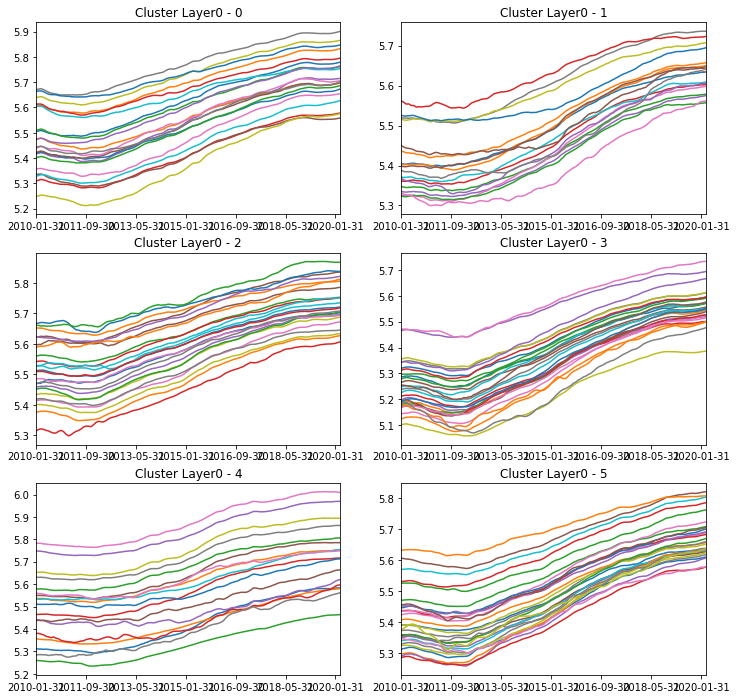

In [64]:
plot_clusters(zillow_info.reset_index()[['zip_code','submktname']],zillow_ts,log=True)

### Hierarchical Clustering

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [18]:
hierarchy = linkage(change, method='ward')

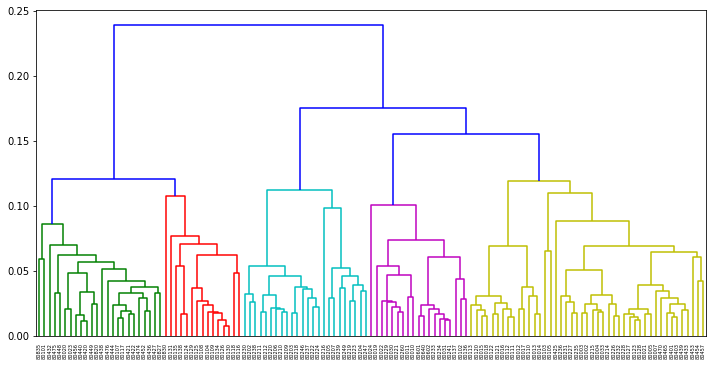

In [25]:
plt.figure(figsize=(12,6))
ans = dendrogram(hierarchy, labels=change.index, color_threshold=0.12)

In [26]:
hclust = fcluster(hierarchy, t=0.12, criterion='distance')

In [31]:
hc_predict = pd.DataFrame({'zip_code':change.index,'cluster':hclust-1})

In [35]:
hc_predict.cluster.value_counts()

4    45
2    24
0    24
3    19
1    15
Name: cluster, dtype: int64

In [36]:
geo_map = make_map(geojson,coor,5,hc_predict)
# geo_map